In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [2]:
# Google Colab specific code for mounting Google Drive (uncomment when in Colab)
# from google.colab import drive
# drive.mount('/content/drive')
# dataset_path = '/content/drive/MyDrive/your_path/merged_walk_data.csv'

# Check if GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the dataset (adjust path for Colab)
dataset_path = 'merged_walk_data.csv'  # Default Colab path
data = pd.read_csv(dataset_path)

# Separate input (X) and output (Y)
gon_data = data.iloc[:, 1:2]  # Y (second column - ankle_sagittal)
full_data = data.iloc[:, 2:]  # X (third column onward - all other features)

# Compute mean and std for normalization
mean_X, std_X = full_data.mean(), full_data.std()
mean_Y, std_Y = gon_data.mean().iloc[0], gon_data.std().iloc[0]

# Normalize both X and Y globally before creating sequences
X_norm = (full_data - mean_X) / std_X
Y_norm = (gon_data - mean_Y) / std_Y

# Define parameters
p = 50  # Past timesteps (input)
f = 10  # Future timesteps (output)

# Prepare training sequences from the normalized dataset
X_data, Y_data = [], []
for i in range(len(full_data) - p - f):
    X_data.append(X_norm.iloc[i:i+p, :].values)  # Input: past 50ms (already normalized)
    Y_data.append(Y_norm.iloc[i+p:i+p+f, :].values)  # Output: next 10ms (already normalized)

X_data = np.array(X_data)  # Shape: (samples, 50, features)
Y_data = np.array(Y_data)  # Shape: (samples, 10, 1)

# Convert numpy arrays to PyTorch tensors
X_data_tensor = torch.FloatTensor(X_data)
Y_data_tensor = torch.FloatTensor(Y_data)

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data_tensor, Y_data_tensor, test_size=0.2, shuffle=False)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# DataLoader provides batching, shuffling, and parallel data loading
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Using device: cuda
X_train shape: torch.Size([215364, 50, 9])
Y_train shape: torch.Size([215364, 10, 1])


TimeSeriesCNN(
  (conv1): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
  (relu2): ReLU()
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
  (relu3): ReLU()
  (fc1): Linear(in_features=3200, out_features=100, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
Saved new best model with val loss: 1.8008
Saved new best model with val loss: 1.7390
Epoch 5/60, Train Loss: 0.0331, Val Loss: 1.8435
Epoch 10/60, Train Loss: 0.0266, Val Loss: 1.8487
Epoch 15/60, Train Loss: 0.0242, Val Loss: 1.8702
Epoch 20/60, Train Loss: 0.0229, Val Loss: 1.8877
Epoch 25/60, Train Loss: 0.0222, Val Loss: 1.7871
Epoch 30/60, Train Loss: 0.0216, Val Loss: 1.8146
Epoch 35/60, Train Loss: 0.0211, Val Loss: 1.8550
Saved new best model with val loss: 1.7160
Epoch 40/60, Train Loss: 0.0208, Val Loss: 1.8597
Epoch 45/60, Tr

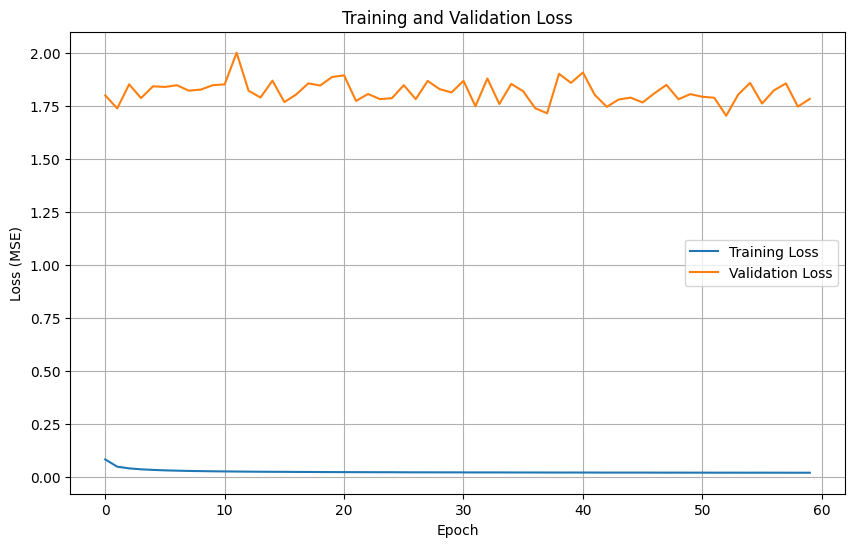

Test Loss (MSE): 2.1578


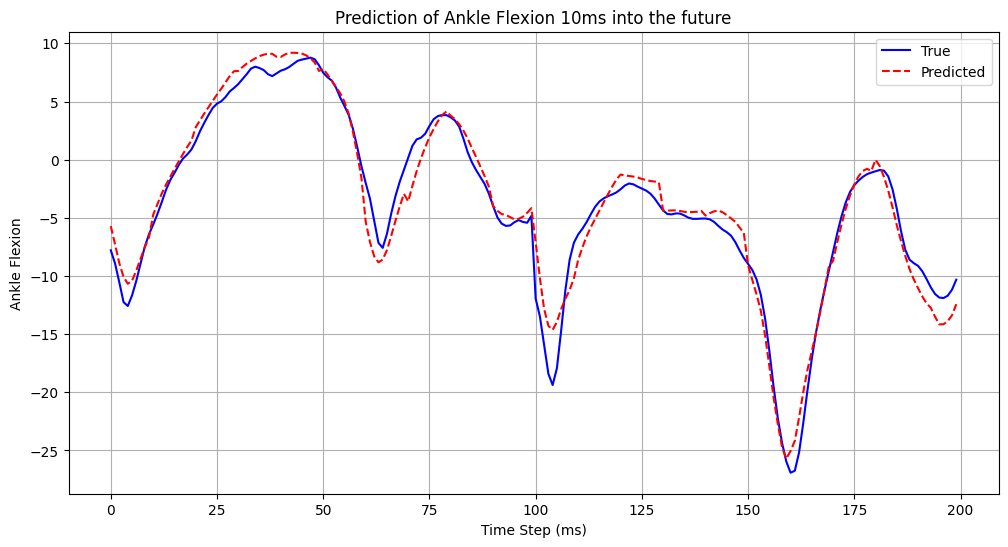

In [3]:
# Define the CNN model using PyTorch's nn.Module
class TimeSeriesCNN(nn.Module):
    def __init__(self, input_channels, output_length=10):
        super(TimeSeriesCNN, self).__init__()

        # First convolutional layer with dilation=1
        # PyTorch Conv1d expects [batch, channels, sequence] format
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1, dilation=1)
        self.relu1 = nn.ReLU()

        # Second convolutional layer with dilation=2 for wider receptive field
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=2, dilation=2)
        self.relu2 = nn.ReLU()

        # Third convolutional layer with dilation=4 for even wider receptive field
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=4, dilation=4)
        self.relu3 = nn.ReLU()

        # Calculate flattened size after convolutions
        # With proper padding, the sequence length remains p (50)
        self.flat_size = 64 * p

        # Fully connected layers for final prediction
        self.fc1 = nn.Linear(self.flat_size, 100)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(100, output_length)

    def forward(self, x):
        # PyTorch Conv1d expects [batch, channels, sequence] but our input is [batch, sequence, channels]
        # So we need to permute the dimensions
        x = x.permute(0, 2, 1)

        # Apply convolutions
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)

        # Reshape to match expected output dimensions [batch, 10, 1]
        x = x.view(x.size(0), f, 1)

        return x

# Initialize the model
input_channels = X_data.shape[2]  # Number of features
model = TimeSeriesCNN(input_channels).to(device)
print(model)  # Print model architecture

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

# Training function for the model
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=60):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            # Gradient clipping (similar to TensorFlow's clipnorm)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():  # No gradients needed for validation
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, '
                f'Train Loss: {epoch_train_loss:.4f}, '
                f'Val Loss: {epoch_val_loss:.4f}')

        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved new best model with val loss: {best_val_loss:.4f}')

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=60)

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Initialize predictions and ground truth for sliding window evaluation
predict_window = 200  # Total prediction window in ms
slide_step = 10  # Slide every 10ms
total_slides = predict_window // slide_step

# Select a random starting index that is a multiple of 100
valid_start_indices = [i for i in range(0, len(data) - (p + f + predict_window), 100)]
if not valid_start_indices:
    raise ValueError("Not enough data to select a valid starting index.")
start_idx = random.choice(valid_start_indices)
end_idx = start_idx + p

predictions = []
true_values = []

# Run predictions with sliding window
with torch.no_grad():  # No gradients needed for inference
    for _ in range(total_slides):
        if end_idx + f > len(data):
            break  # Avoid exceeding dataset length

        # Normalize input using the training mean and std
        X_input_np = ((full_data.iloc[start_idx:end_idx, :] - mean_X) / std_X).values
        X_input = torch.FloatTensor(X_input_np).unsqueeze(0).to(device)  # Add batch dimension

        # Extract true values
        Y_true = gon_data.iloc[end_idx:end_idx + f, :].values

        # Make prediction
        Y_pred = model(X_input).cpu().numpy()

        # Denormalize predictions
        Y_pred = Y_pred * std_Y + mean_Y

        predictions.append(Y_pred.squeeze())  # Store predictions
        true_values.append(Y_true.squeeze())  # Store true values

        # Move sliding window
        start_idx += slide_step
        end_idx += slide_step

# Convert lists to numpy arrays
predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

# Compute test loss (Mean Squared Error)
test_loss = np.mean((predictions - true_values) ** 2)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(predict_window), true_values, label='True', linestyle='-', color='b')
plt.plot(np.arange(predict_window), predictions, label='Predicted', linestyle='--', color='r')
plt.title('Prediction of Ankle Flexion 10ms into the future')
plt.xlabel('Time Step (ms)')
plt.ylabel('Ankle Flexion')
plt.legend()
plt.grid(True)
plt.show()